# Experiment 1:
## Behaviour of BIHT/BIP and regularized optimization problems on MNIST


This experiment shows the behaviour of the Binary Iterative Hard Thresholding/Projection method and the regularized optimization method on the MNIST when using the following structural assumptions on the signal set:
- Sparsity in standard basis,
- Sparsity in Fourier basis,
- Sparsity in single level 2D Haar wavelets and
- Generative model.


The specific choice of sparsity levels and generative model parameters were chosen empirically.

In [1]:
import numpy as np;
import numpy.linalg as linalg;

import matplotlib.pyplot as plt;

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torch.optim as optim;

import pywt;

from torch.utils.data import DataLoader;
import torchvision;

import pickle;
import time;
import random;
import math;

from IPython.display import clear_output;

import MNIST_utils as MNIST;
import MNIST_generative as generative;
import sparsity_utils as sparsity;
import general_utils as utils;

# Initialization

In [2]:
(train_data, test_data), (train_loader, test_loader) = MNIST.load_dataset();

noise = 0.1;
mspace = np.linspace(1, 3000, 20, dtype=int);
mspace_fourier = np.linspace(1, 3000, 20, dtype=int);
mspace_haar = np.linspace(1, 1500, 20, dtype=int);
mspace_gen = np.linspace(1, 400, 20, dtype=int);

repetitions = 3;

inv_reg_param = np.sqrt(2.0/(np.pi*(1+noise*noise)));

standard_sparsity = 100;
fourier_sparsity = 100;
haar_sparsity = 40;

# Sparsity experiment

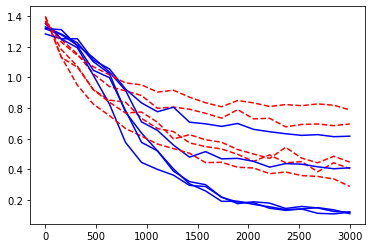

In [6]:
def fixed_sparsity_experiment_BIP(x, s, mspace, repetitions):
    acc = len(mspace)*[0];
    for i in range(len(mspace)):
        m = mspace[i];
        average = 0;
        for j in range(repetitions):
            A, q = utils.generateMeasurements_Gaussian(x, m, noise);
            q = utils.quantize(q);
            _, accuracy = MNIST.reconstruct_BIP(A, q, x, lambda x : sparsity.HT(x, s));
            average = average + accuracy;
        acc[i] = average/repetitions;
    return acc;

def fixed_sparsity_experiment_convex(x, s, mspace, repetitions):
    acc = len(mspace)*[0];
    for i in range(len(mspace)):
        m = mspace[i];
        average = 0;
        for j in range(repetitions):
            A, q = utils.generateMeasurements_Gaussian(x, m, noise);
            q = utils.quantize(q);
            _, accuracy = MNIST.reconstruct_regularized(A, q, x, lambda x : sparsity.HT(x, s), inv_reg_param);
            average = average + accuracy;
        acc[i] = average/repetitions;
    return acc;

data_BIHT = [];
data_convex = [];

utils.reset_seeds();
for j in range(5):
    x = MNIST.getImageAsVector(test_loader, j);
    acc = fixed_sparsity_experiment_BIP(x, standard_sparsity, mspace, repetitions);
    data_BIHT.append([]);
    data_BIHT[j] = acc;
    
    acc = fixed_sparsity_experiment_convex(x, standard_sparsity, mspace, repetitions);
    data_convex.append([]);
    data_convex[j] = acc;
    
    clear_output(wait=True);
    for i in range(len(data_BIHT)):
        plt.plot(mspace, data_BIHT[i], 'b-');
        plt.plot(mspace, data_convex[i], 'r--');
    plt.show();

In [5]:
utils.saveData((data_BIHT, data_convex), "results_data/1_standard.data");

# Fourier experiment

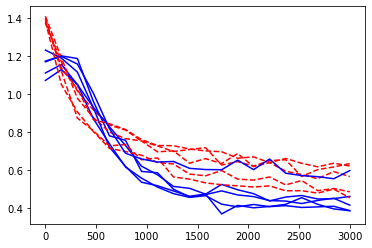

In [6]:
def fixed_sparsity_experiment_BIP(x, s, mspace, repetitions):
    acc = len(mspace)*[0];
    for i in range(len(mspace)):
        m = mspace[i];
        average = 0;
        for j in range(repetitions):
            A, q = utils.generateMeasurements_Gaussian(x, m, noise);
            q = utils.quantize(q);
            _, accuracy = MNIST.reconstruct_BIP(A, q, x,
                                          lambda x : sparsity.HT_transform(x, s, sparsity.fourier2d, sparsity.inverse_fourier2d),
                                          learning_param = 0.0005, iterations = 500);
            average = average + accuracy;
        acc[i] = average/repetitions;
    return acc;

def fixed_sparsity_experiment_convex(x, s, mspace, repetitions):
    acc = len(mspace)*[0];
    for i in range(len(mspace)):
        m = mspace[i];
        average = 0;
        for j in range(repetitions):
            A, q = utils.generateMeasurements_Gaussian(x, m, noise);
            q = utils.quantize(q);
            _, accuracy = MNIST.reconstruct_regularized(A, q, x,
                                          lambda x : sparsity.HT_transform(x, s, sparsity.fourier2d, sparsity.inverse_fourier2d),
                                                   inv_reg_param);
            average = average + accuracy;
        acc[i] = average/repetitions;
    return acc;

data_BIHT_ft = [];
data_convex_ft = [];

utils.reset_seeds();
for j in range(5):
    x = MNIST.getImageAsVector(test_loader, j);
    acc = fixed_sparsity_experiment_BIP(x, fourier_sparsity, mspace_fourier, repetitions);
    data_BIHT_ft.append([]);
    data_BIHT_ft[j] = acc;
    
    acc = fixed_sparsity_experiment_convex(x, fourier_sparsity, mspace_fourier, repetitions);
    data_convex_ft.append([]);
    data_convex_ft[j] = acc;
    
    clear_output(wait=True);
    for i in range(len(data_BIHT_ft)):
        plt.plot(mspace, data_BIHT_ft[i], 'b-');
        plt.plot(mspace, data_convex_ft[i], 'r--');
    plt.show();

In [7]:
utils.saveData((data_BIHT_ft, data_convex_ft), "results_data/1_fourier.data");

# single level 2D Haar wavelets experiments

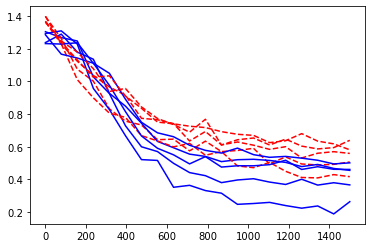

In [8]:
def fixed_sparsity_experiment_BIP(x, s, mspace, repetitions):
    acc = len(mspace)*[0];
    for i in range(len(mspace)):
        m = mspace[i];
        average = 0;
        for j in range(repetitions):
            A, q = utils.generateMeasurements_Gaussian(x, m, noise);
            q = utils.quantize(q);
            _, accuracy = MNIST.reconstruct_BIP(A, q, x,
                                          lambda x : sparsity.HT_transform(x, s, sparsity.haar2d, sparsity.inverse_haar2d));
            average = average + accuracy;
        acc[i] = average/repetitions;
    return acc;

def fixed_sparsity_experiment_convex(x, s, mspace, repetitions):
    acc = len(mspace)*[0];
    for i in range(len(mspace)):
        m = mspace[i];
        average = 0;
        for j in range(repetitions):
            A, q = utils.generateMeasurements_Gaussian(x, m, noise);
            q = utils.quantize(q);
            _, accuracy = MNIST.reconstruct_regularized(A, q, x,
                                          lambda x : sparsity.HT_transform(x, s, sparsity.haar2d, sparsity.inverse_haar2d),
                                                   inv_reg_param);
            average = average + accuracy;
        acc[i] = average/repetitions;
    return acc;

data_BIHT_haar = [];
data_convex_haar = [];

utils.reset_seeds();
for j in range(5):
    x= MNIST.getImageAsVector(test_loader, j);
    acc = fixed_sparsity_experiment_BIP(x, haar_sparsity, mspace_haar, repetitions);
    data_BIHT_haar.append([]);
    data_BIHT_haar[j] = acc;
    
    acc = fixed_sparsity_experiment_convex(x, haar_sparsity, mspace_haar, repetitions);
    data_convex_haar.append([]);
    data_convex_haar[j] = acc;
    
    clear_output(wait=True);
    for i in range(len(data_BIHT_haar)):
        plt.plot(mspace_haar, data_BIHT_haar[i], 'b-');
        plt.plot(mspace_haar, data_convex_haar[i], 'r--');
    plt.show();

In [9]:
utils.saveData((data_BIHT_haar, data_convex_haar), "results_data/1_haar.data");

# Generative model experiment

In [6]:
utils.reset_seeds();
_, autoEncoder = generative.createNetwork(3, 100);
generative.trainNetwork(autoEncoder, train_loader);

projector = lambda x : generative.project(x, autoEncoder , num_epochs = 20, learning_rate = 0.001);

C:\Users\jever\anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	 Train_loss: 1.069325
Epoch: 2 	 Train_loss: 0.498542
Epoch: 3 	 Train_loss: 0.370502
Epoch: 4 	 Train_loss: 0.312300
Epoch: 5 	 Train_loss: 0.281547
Epoch: 6 	 Train_loss: 0.260119
Epoch: 7 	 Train_loss: 0.243736
Epoch: 8 	 Train_loss: 0.231814
Epoch: 9 	 Train_loss: 0.222426
Epoch: 10 	 Train_loss: 0.214850
Epoch: 11 	 Train_loss: 0.207706
Epoch: 12 	 Train_loss: 0.202160
Epoch: 13 	 Train_loss: 0.197265
Epoch: 14 	 Train_loss: 0.192909
Epoch: 15 	 Train_loss: 0.188500
Epoch: 16 	 Train_loss: 0.183898
Epoch: 17 	 Train_loss: 0.179991
Epoch: 18 	 Train_loss: 0.175919
Epoch: 19 	 Train_loss: 0.172831
Epoch: 20 	 Train_loss: 0.169244


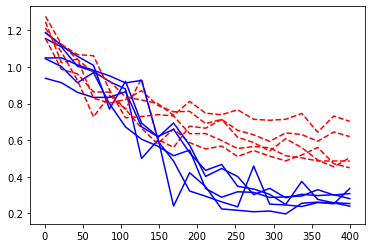

In [8]:
def fixed_sparsity_experiment_BIP(x, mspace, repetitions):
    acc = len(mspace)*[0];
    for i in range(len(mspace)):
        m = mspace[i];
        average = 0;
        for j in range(repetitions):
            A, q = utils.generateMeasurements_Gaussian(x, m, noise);
            q = utils.quantize(q);
            _, accuracy = MNIST.reconstruct_BIP(A, q, x, projector,
                              learning_param = 0.02, iterations = 50);
            average = average + accuracy;
        acc[i] = average/repetitions;
        print(m, acc[i]);
    return acc;

def fixed_sparsity_experiment_convex(x, mspace, repetitions):
    acc = len(mspace)*[0];
    for i in range(len(mspace)):
        m = mspace[i];
        average = 0;
        for j in range(repetitions):
            A, q = utils.generateMeasurements_Gaussian(x, m, noise);
            q = utils.quantize(q);
            _, accuracy = MNIST.reconstruct_regularized(A, q, x, projector, inv_reg_param,
                                             learning_param = 0.8, iterations = 50);
            average = average + accuracy;
        acc[i] = average/repetitions;
        print(m, acc[i]);
    return acc;

data_BIHT_gen = [];
data_convex_gen = [];

utils.reset_seeds();
for j in range(5):
    x = MNIST.getImageAsVector(test_loader, j);
    acc = fixed_sparsity_experiment_BIP(x, mspace_gen, repetitions);
    data_BIHT_gen.append([]);
    data_BIHT_gen[j] = acc;
    
    acc = fixed_sparsity_experiment_convex(x, mspace_gen, repetitions);
    data_convex_gen.append([]);
    data_convex_gen[j] = acc;
    
    clear_output(wait=True);
    for i in range(len(data_BIHT_gen)):
        plt.plot(mspace_gen, data_BIHT_gen[i], 'b-');
        plt.plot(mspace_gen, data_convex_gen[i], 'r--');
    plt.show();

In [9]:
utils.saveData((data_BIHT_gen, data_convex_gen), "results_data/1_generative.data");

# Further processing

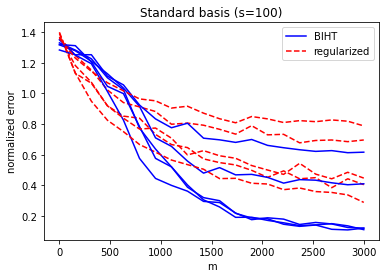

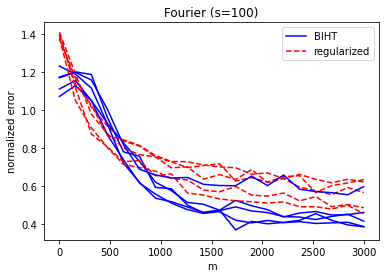

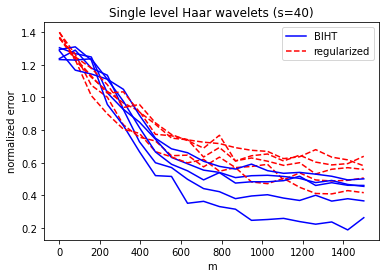

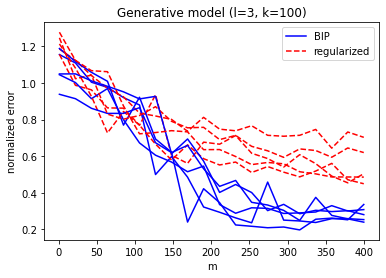

In [7]:
# Load data
(data_BIHT,      data_convex)      = utils.loadData("results_data/1_standard.data");
(data_BIHT_ft,   data_convex_ft)   = utils.loadData("results_data/1_fourier.data");
(data_BIHT_haar, data_convex_haar) = utils.loadData("results_data/1_haar.data");
(data_BIHT_gen,  data_convex_gen)  = utils.loadData("results_data/1_generative.data");


# Sparsity
for i in range(len(data_BIHT)):
    plt.plot(mspace, data_BIHT[i], 'b-');
    plt.plot(mspace, data_convex[i], 'r--');

plt.title("Standard basis (s=100)");
plt.xlabel("m");
plt.ylabel("normalized error");
plt.legend(["BIHT", "regularized"]);
plt.savefig("results_images/biht_vs_convex_sparsity_noise01.png", dpi=200);
plt.show();

# Fourier
for i in range(len(data_BIHT)):
    plt.plot(mspace, data_BIHT_ft[i], 'b-');
    plt.plot(mspace, data_convex_ft[i], 'r--');

plt.title("Fourier (s=100)");    
plt.xlabel("m");
plt.ylabel("normalized error");
plt.legend(["BIHT", "regularized"]);
plt.savefig("results_images/biht_vs_convex_fourier_noise01.png", dpi=200);
plt.show();

# Wavelet
for i in range(len(data_BIHT)):
    plt.plot(mspace_haar, data_BIHT_haar[i], 'b-');
    plt.plot(mspace_haar, data_convex_haar[i], 'r--');

plt.title("Single level Haar wavelets (s=40)");  
plt.xlabel("m");
plt.ylabel("normalized error");  
plt.legend(["BIHT", "regularized"]);
plt.savefig("results_images/biht_vs_convex_haar_noise01.png", dpi=200);
plt.show();

# Generative
for i in range(len(data_BIHT)):
    plt.plot(mspace_gen, data_BIHT_gen[i], 'b-');
    plt.plot(mspace_gen, data_convex_gen[i], 'r--');
    
plt.title("Generative model (l=3, k=100)");   
plt.xlabel("m");
plt.ylabel("normalized error"); 
plt.legend(["BIP", "regularized"]);
plt.savefig("results_images/biht_vs_convex_gen_noise01.png", dpi=200);
plt.show();